In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import os
print(os.listdir())

['concatenated_results.csv', '1605T100817', '1313T030817', 'plot_bayesian_posterior.ipynb', '1608T100817', '.ipynb_checkpoints', 'DataMerge.ipynb', '1614T100817']


In [2]:
result = pd.DataFrame()
#pfile=os.path.join('1313T030817','parameters.csv')
pfile='concatenated_results.csv'
num_lines = sum(1 for line in open(pfile))-1
df = pd.read_csv(pfile, chunksize=10000, index_col='idx')
for chunk in df:
    #chunk.dropna(axis=0, inplace=True) # Dropping all rows with any NaN value
    chunk.fillna(100000, inplace=True)
    result = result.append(chunk)

print("Number of lines:\t{}".format(num_lines))
print("Number of NaN values:\t{}".format(num_lines-sum(pd.notnull(result['euclidean']))))

Number of lines:	299997
Number of NaN values:	0


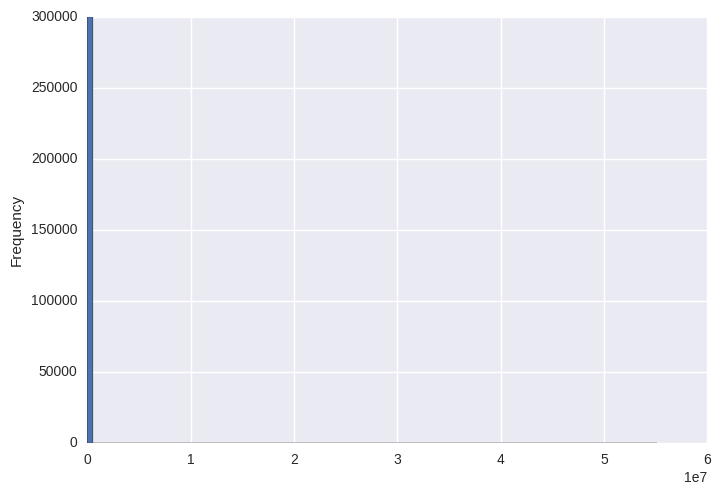

In [3]:
result['euclidean'].plot(kind='hist', bins=100)

Zoom in to lowest 1% of distances to get a better idea of how they are distributed at the bottom end.

Index(['MAE', 'MSE', 'Vol_mit', 'cytox_tot_tis', 'euclidean', 'manhattan',
       'r_0', 'r_m', 'r_t'],
      dtype='object')


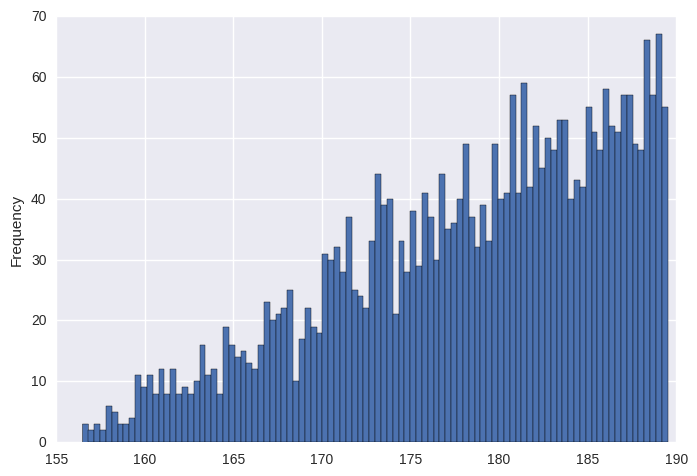

In [4]:
result.sort_values(by='euclidean', inplace=True)
print(result.columns)
result['euclidean'].iloc[:int(num_lines/100)].plot(kind='hist', bins=100)

# Obtaining posteriors #
From the current OpenOpt framework, a distance of about 165 has been obtained as a best fit. Adding a small amount on to this to allow for the fact that 165 is not a "truly" best fit - a lower value may be possible and a slightly higher value may be considered a reasonable fit overall.

/home/buck06191/anaconda3/envs/data/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


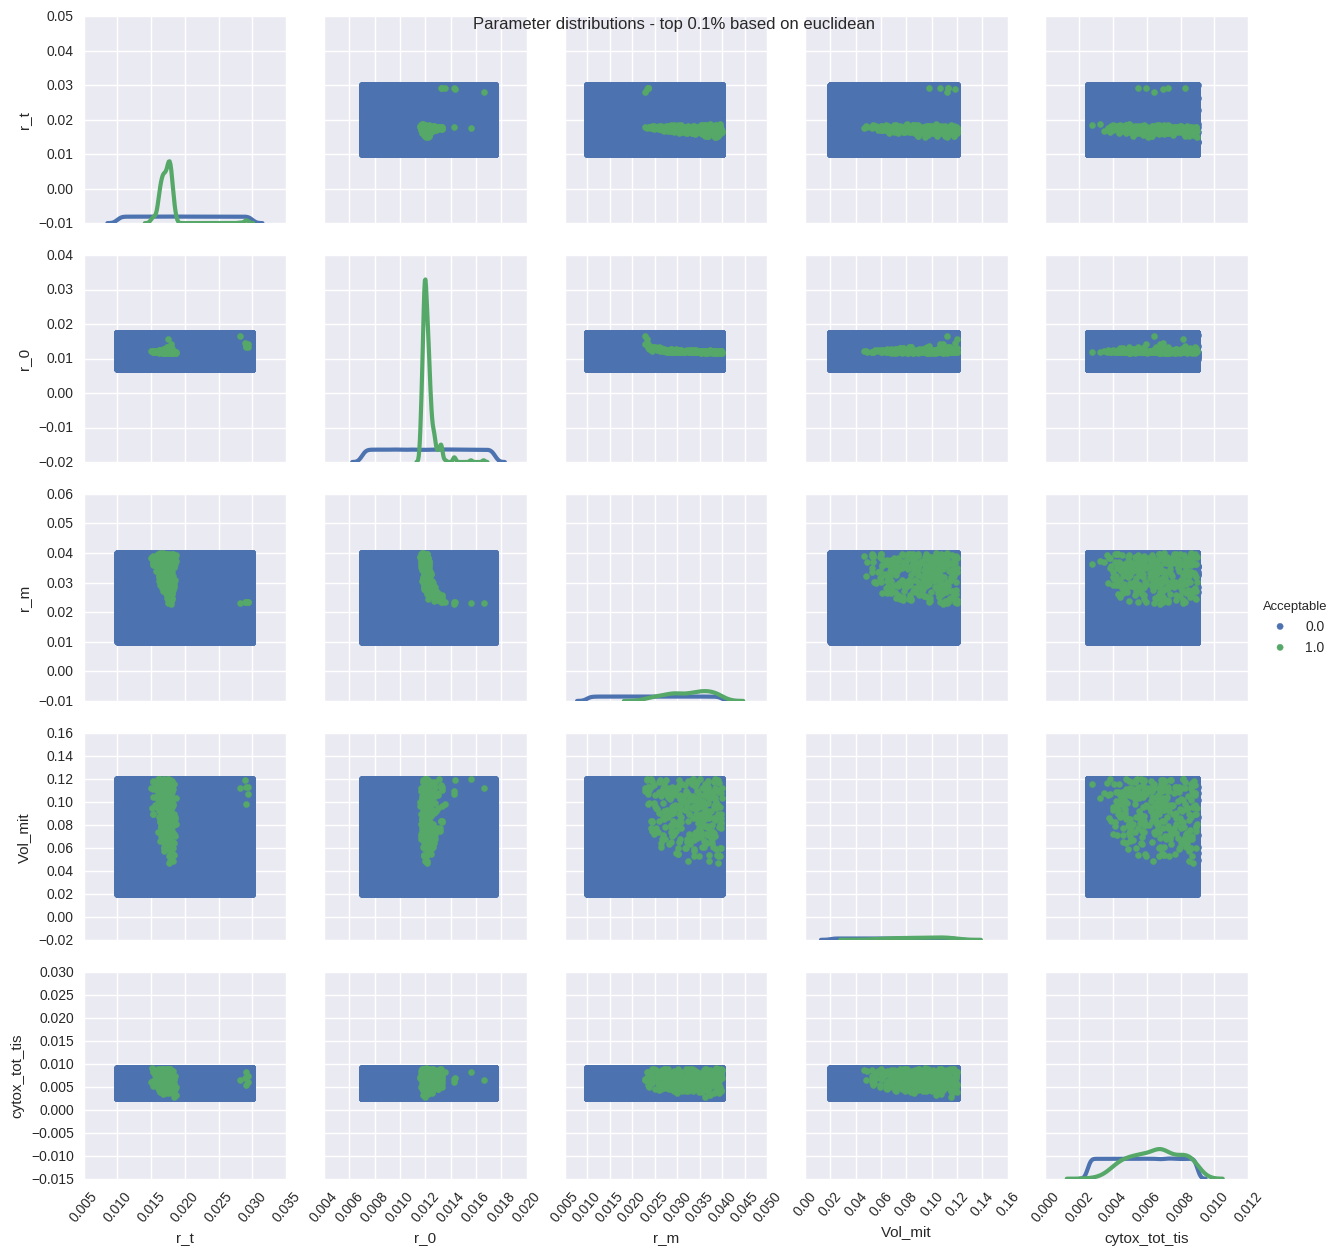

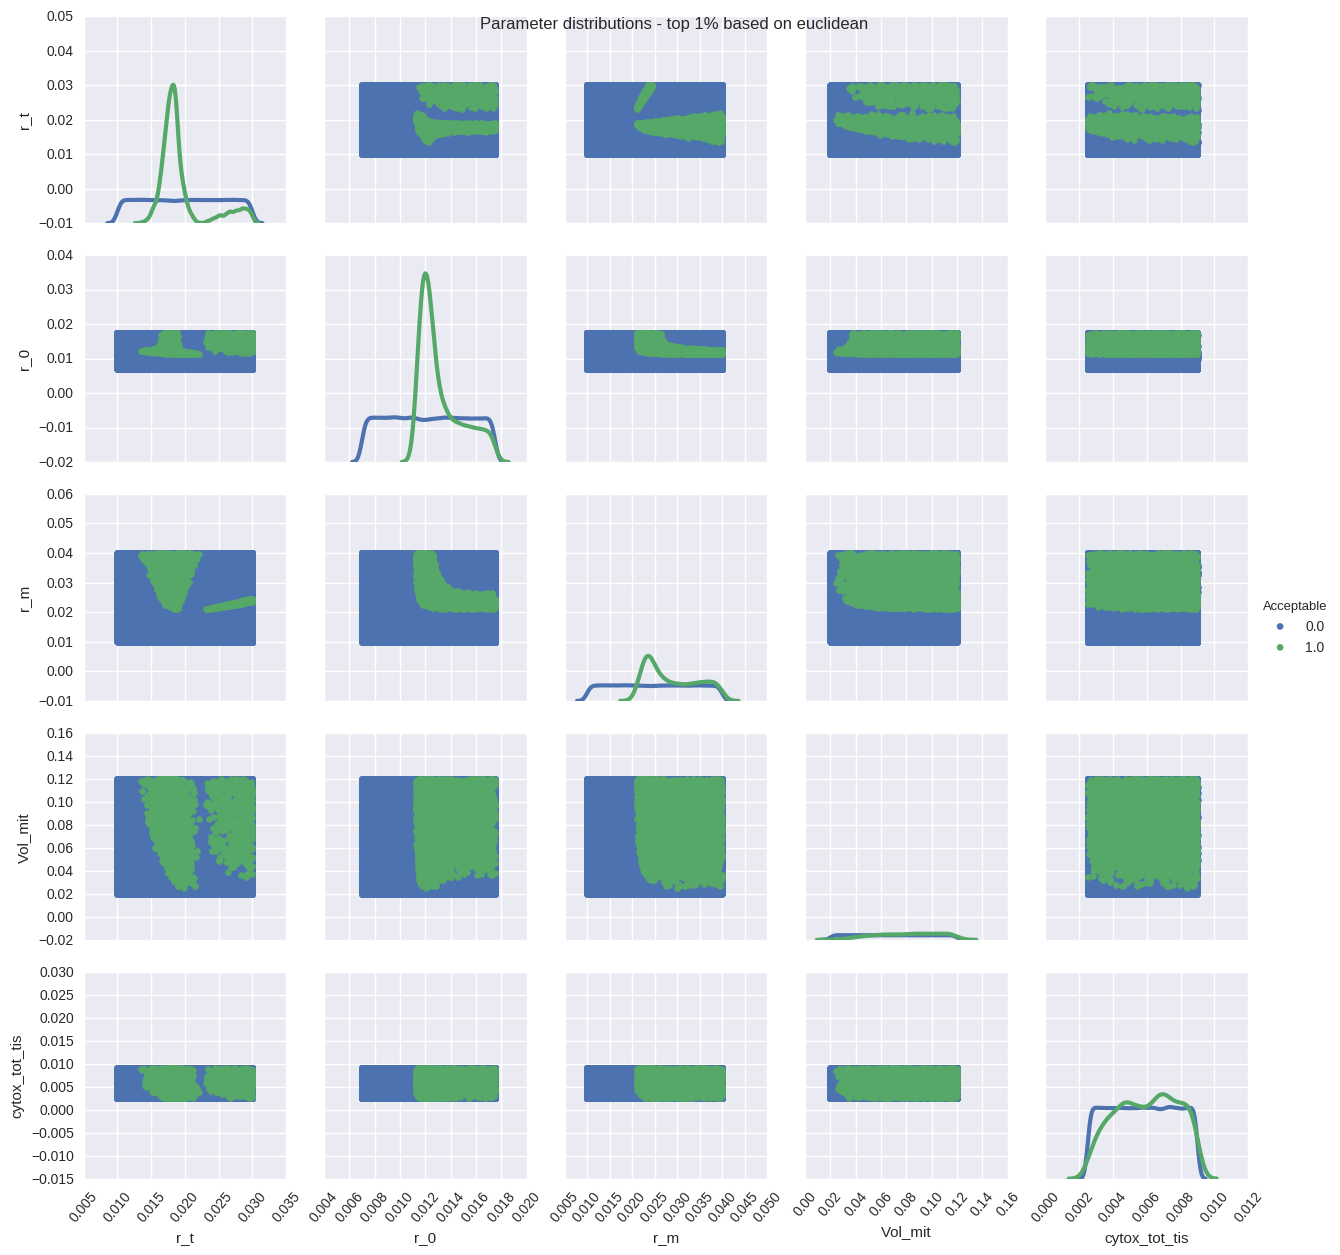

In [5]:
distances = ['euclidean','MSE', 'MAE']
for d in ['euclidean']:
    plt.figure()

    result['Acceptable'] = np.zeros(len(result))
    result.sort_values(by=d, inplace=True)
    #acceptable_idx = result[d] < 175
    #result['Acceptable'].ix[acceptable_idx] = 1
    result['Acceptable'].iloc[:int(num_lines/1000)] = 1
    g = sns.PairGrid(result, vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'], hue='Acceptable')
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.map_offdiag(plt.scatter)
    g.add_legend()
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(50)
    plt.suptitle("Parameter distributions - top 0.1% based on {}".format(d))
    
    plt.figure()

    result['Acceptable'] = np.zeros(len(result))
    result.sort_values(by=d, inplace=True)
    #acceptable_idx = result[d] < 175
    #result['Acceptable'].ix[acceptable_idx] = 1
    result['Acceptable'].iloc[:int(num_lines/100)] = 1
    g = sns.PairGrid(result, vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'], hue='Acceptable')
    g.map_diag(sns.kdeplot, lw=3, legend=False)
    g.map_offdiag(plt.scatter)
    g.add_legend()
    for ax in g.axes.flat:
        for label in ax.get_xticklabels():
            label.set_rotation(50)
    plt.suptitle("Parameter distributions - top 1% based on {}".format(d))
    

# Distributions #
The following plots show the top 0.1% and top 1% of parameters. They are plotted as KDE plots, and histograms of the general distributions is also included.

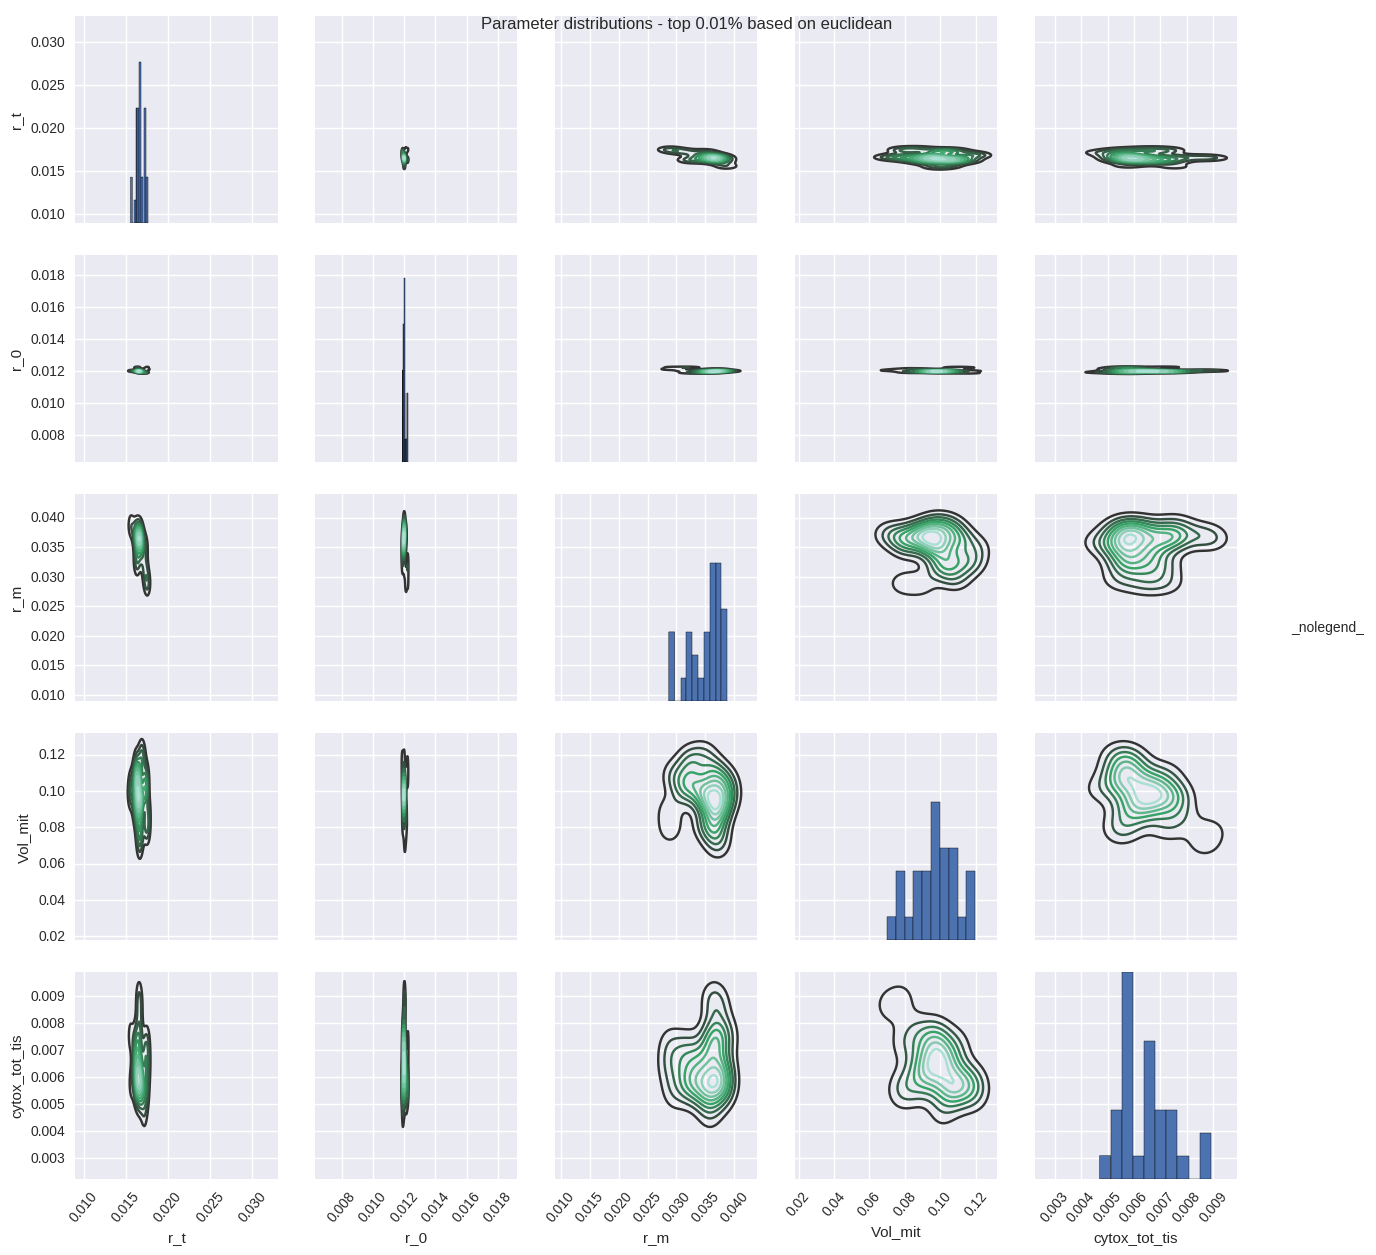

In [204]:
d = 'euclidean'
params = ['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis']
result.sort_values(by=d, inplace=True)
g = sns.PairGrid(result.iloc[:int(num_lines/10000)], vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'])
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, lw=3, legend=False)
g.add_legend()
for ii, ax in enumerate(g.axes.flat):
    for label in ax.get_xticklabels():
        label.set_rotation(50)
    #print("Ylim: {}, {}".format(min(result[params[ii//5]]),max(result[params[ii//5]])))
    #print("Xlim: {}, {}".format(min(result[params[ii%5]]), max(result[params[ii%5]])))
    ax.set_ylim(0.9*min(result[params[ii//5]]), 1.1*max(result[params[ii//5]]))
    ax.set_xlim(0.9*min(result[params[ii%5]]), 1.1*max(result[params[ii%5]]))
plt.suptitle("Parameter distributions - top 0.01% based on {}".format(d))

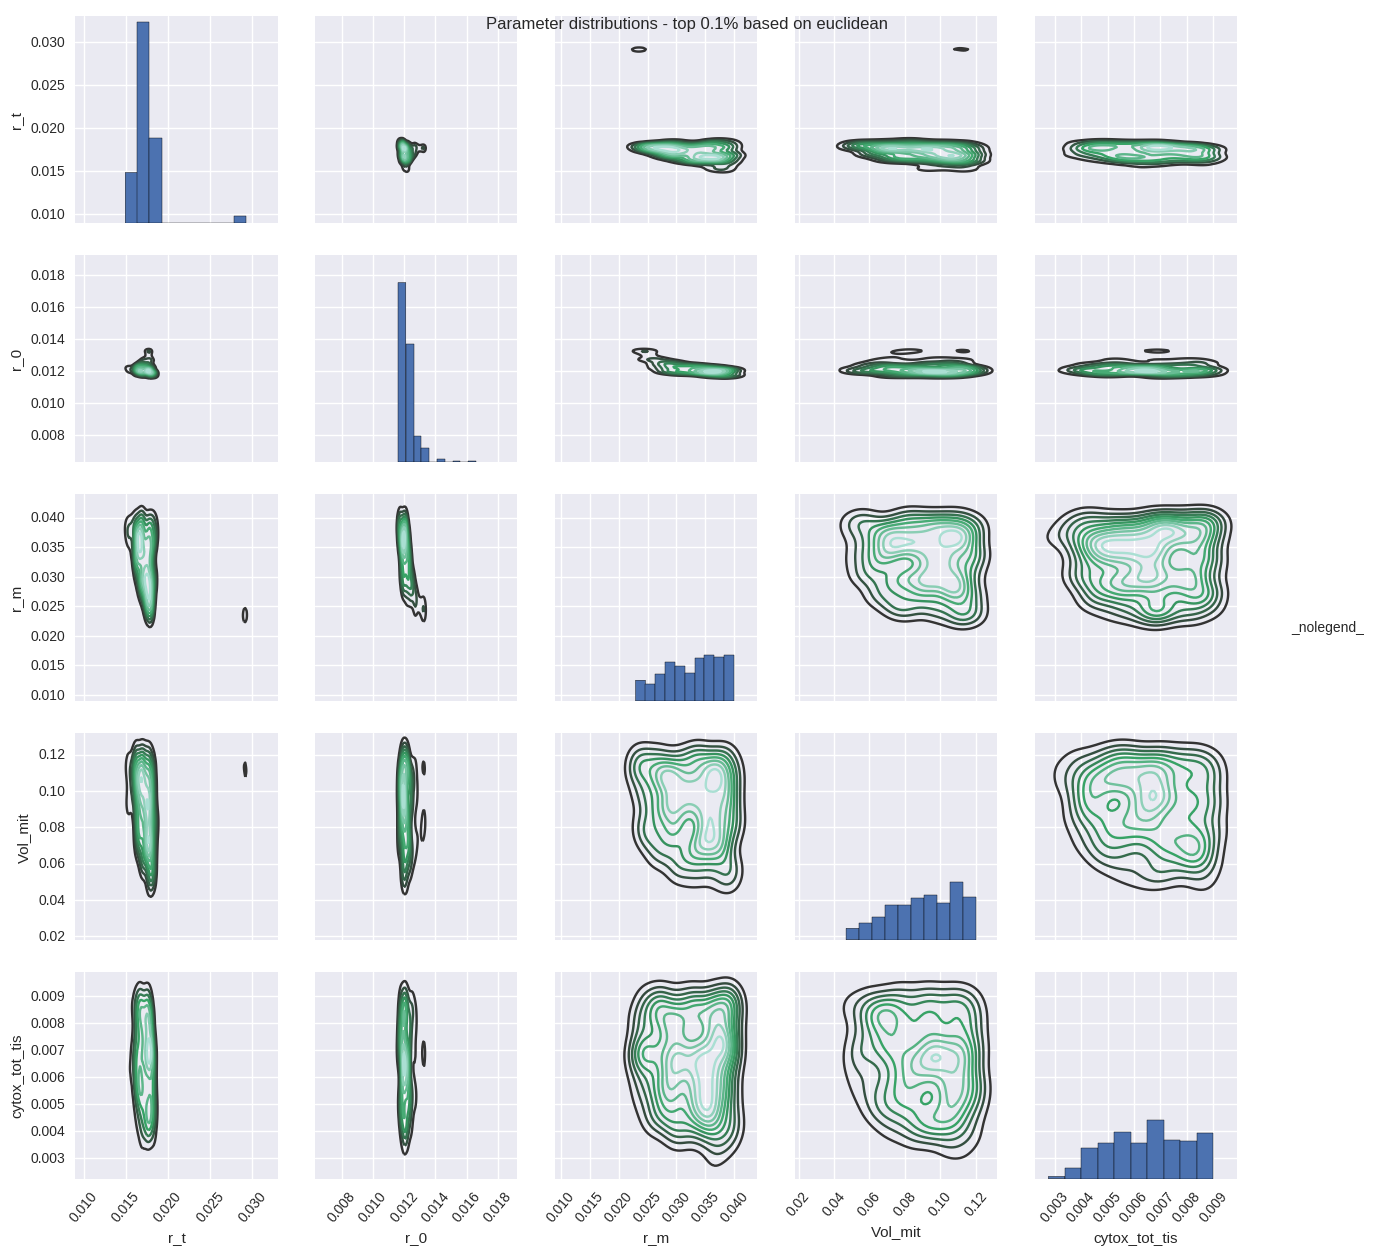

In [205]:
d = 'euclidean'
params = ['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis']
result.sort_values(by=d, inplace=True)
g = sns.PairGrid(result.iloc[:int(num_lines/1000)], vars=['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis'])
g.map_diag(plt.hist)
g.map_offdiag(sns.kdeplot, lw=3, legend=False)
g.add_legend()
for ii, ax in enumerate(g.axes.flat):
    for label in ax.get_xticklabels():
        label.set_rotation(50)
    #print("Ylim: {}, {}".format(min(result[params[ii//5]]),max(result[params[ii//5]])))
    #print("Xlim: {}, {}".format(min(result[params[ii%5]]), max(result[params[ii%5]])))
    ax.set_ylim(0.9*min(result[params[ii//5]]), 1.1*max(result[params[ii//5]]))
    ax.set_xlim(0.9*min(result[params[ii%5]]), 1.1*max(result[params[ii%5]]))
plt.suptitle("Parameter distributions - top 0.1% based on {}".format(d))

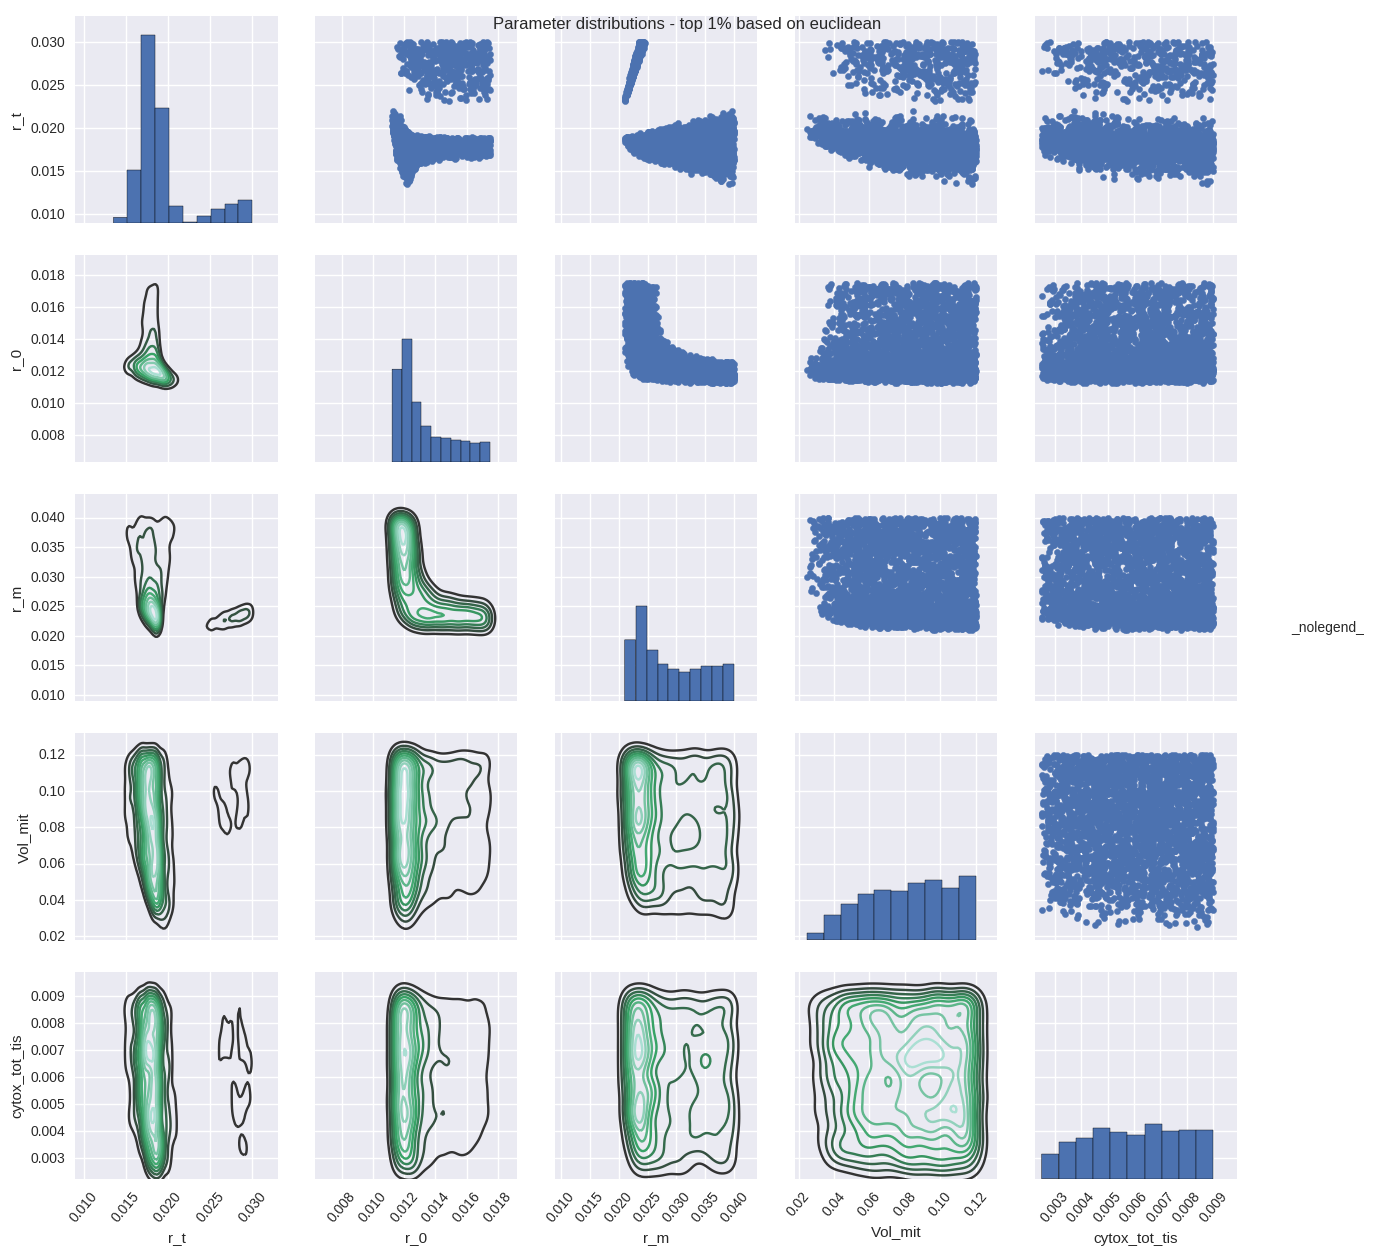

In [206]:
result.sort_values(by=d, inplace=True)
g = sns.PairGrid(result.iloc[:int(num_lines/100)], vars=params)
g.map_diag(plt.hist)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, lw=3, legend=False)
g.add_legend()
for ii, ax in enumerate(g.axes.flat):
    for label in ax.get_xticklabels():
        label.set_rotation(50)
    ax.set_ylim(0.9*min(result[params[ii//5]]), 1.1*max(result[params[ii//5]]))
    ax.set_xlim(0.9*min(result[params[ii%5]]), 1.1*max(result[params[ii%5]]))
plt.suptitle("Parameter distributions - top 1% based on {}".format(d))

## Resampling ##


In [8]:
from scipy import stats

In [209]:
posterior = {}
for frac in [0.01,0.001,0.0001]:
    d = 'euclidean'
    params = ['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis']
    result.sort_values(by=d, inplace=True)
    p = result.iloc[:int(num_lines*frac)][params].as_matrix()
    posterior[frac] = stats.gaussian_kde(p.T).resample(1)

In [210]:
posterior

{0.0001: array([[ 0.01630779],
        [ 0.01200745],
        [ 0.03575179],
        [ 0.08774928],
        [ 0.00909191]]), 0.001: array([[ 0.0184678 ],
        [ 0.01264091],
        [ 0.030187  ],
        [ 0.10266714],
        [ 0.00448117]]), 0.01: array([[ 0.02048695],
        [ 0.01490336],
        [ 0.02163627],
        [ 0.13297086],
        [ 0.00475853]])}

# Run Model #

In [191]:
import sys
sys.path.append('../../..')

In [192]:
from bayescmd.util import findBaseDir

In [193]:
BASEDIR = os.path.abspath(findBaseDir('BayesCMD'))


STARTING AT: /home/buck06191/repos/GitHub/BayesCMD/bayescmd
 Looking for: BayesCMD


In [194]:
os.environ['BASEDIR']='BayesCMD'

In [195]:
from bayescmd.bcmdModel import ModelBCMD

In [196]:
input_path = os.path.join(BASEDIR,'data','hx01.csv')
openopt_path = os.path.join(BASEDIR,'data','hx01_611.csv')

In [197]:
true_data = pd.read_csv(input_path)
openopt_data = pd.read_csv(openopt_path)

In [198]:
outputs = ['Vmca','CCO']
model_name = 'BS'
inputs = ['Pa_CO2', 'P_a', 'SaO2sup']
times = true_data['t'].as_matrix()

{'r_t': 0.016373224982259415, 'r_0': 0.011994004858472148, 'Vol_mit': 0.1059092391974096, 'cytox_tot_tis': 0.00585605191340132, 'r_m': 0.038292669196521481}


In [199]:
from bayescmd.abc import inputParse, import_actual_data
d0 = import_actual_data(input_path)
input_data = inputParse(d0, inputs)

In [200]:
def run_model(model):
    model.create_initialised_input()
    model.run_from_buffer()
    output = model.output_parse()
    return output


In [238]:
def plot_output(posterior_sample):
    # run model and collect output
    param_names = ['r_t', 'r_0', 'r_m', 'Vol_mit', 'cytox_tot_tis']
    params = dict(zip(param_names, [l for i in posterior_sample[1] for l in i]))
    print(posterior_sample[0])
    print(params)
    model = ModelBCMD(model_name,
                     inputs=input_data,
                     params=params,
                     times=times,
                     outputs=outputs)
    output = run_model(model)
    try:
        out_df = pd.DataFrame(data=output)
    except ValueError:
        print(output)
    fig, ax = plt.subplots(2)
    ax[0].plot(times, out_df['CCO'], 'b', label='Bayesian')
    ax[0].plot(times, true_data['CCO'], 'g', label='True')
    ax[0].plot(times, openopt_data['CCO'], 'r', label='openopt')
    ax[0].set_title('CCO')
    ax[0].legend()

    ax[1].plot(times, out_df['Vmca'], 'b', label='Bayesian')
    ax[1].plot(times, true_data['Vmca'], 'g', label='True')
    ax[1].plot(times, openopt_data['Vmca'], 'r', label='openopt')
    ax[1].set_title('Vmca')
    ax[1].legend()
    fig.suptitle("Parameter distributions - top {} of data".format(posterior_sample[0]))

0.0001
{'r_t': 0.016307785053225443, 'r_0': 0.012007448157073193, 'Vol_mit': 0.087749276316621647, 'cytox_tot_tis': 0.0090919110867930912, 'r_m': 0.03575178526536555}
0.001
{'r_t': 0.018467800555600038, 'r_0': 0.012640910672728593, 'Vol_mit': 0.10266714152275247, 'cytox_tot_tis': 0.0044811650175455766, 'r_m': 0.030187001912197725}


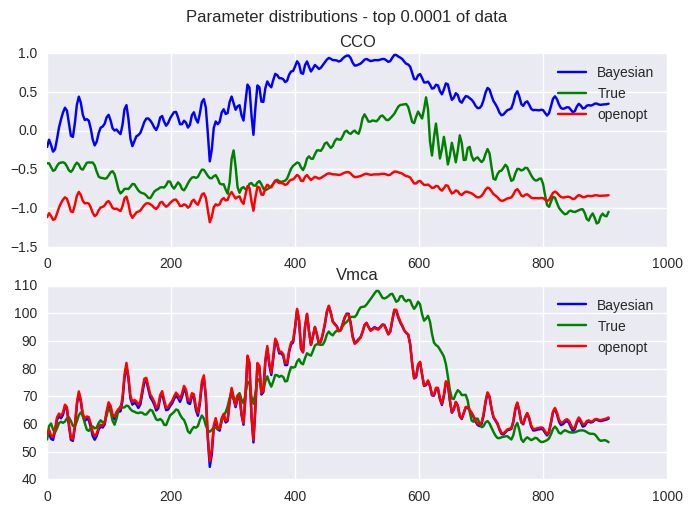

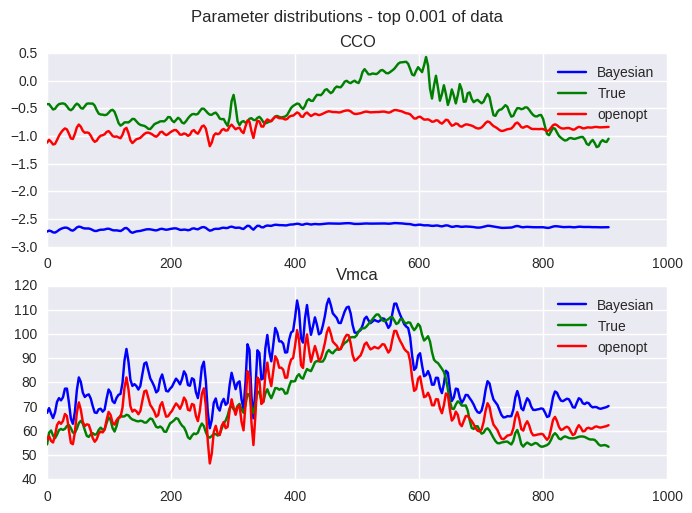

In [242]:
for ps in posterior.items():
    if ps[0]==0.01:
        continue
    #print(ps)
    plot_output(ps)

In [202]:
out_df = pd.DataFrame(data=output)
out_df.head()

,CCO,P_a,Pa_CO2,SaO2sup,Vmca,t
0,-2.401024,89.841831,36.003184,0.939740,56.908946,0.0
1,-2.341613,92.545507,35.828492,0.945999,58.375296,3.2
2,-2.384389,90.660671,36.527322,0.945421,56.268168,6.4
3,-2.440627,86.150107,37.705610,0.937248,55.685659,9.6
4,-2.426953,84.350073,38.366301,0.929208,58.676980,12.8


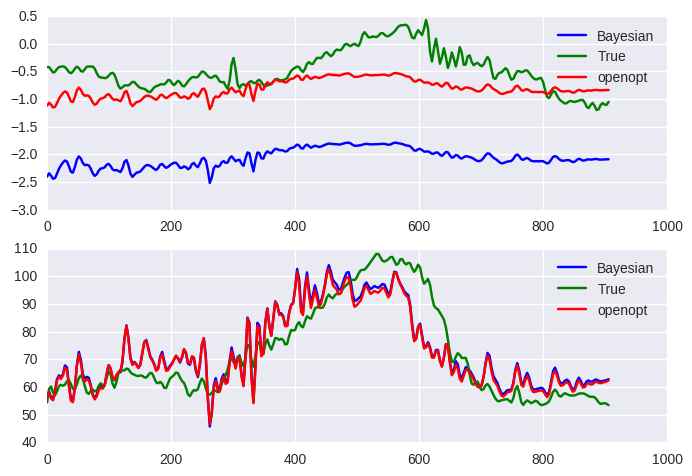

In [203]:
fig, ax = plt.subplots(2)
ax[0].plot(times, out_df['CCO'], 'b', label='Bayesian')
ax[0].plot(times, true_data['CCO'], 'g', label='True')
ax[0].plot(times, openopt_data['CCO'], 'r', label='openopt')
ax[0].legend()

ax[1].plot(times, out_df['Vmca'], 'b', label='Bayesian')
ax[1].plot(times, true_data['Vmca'], 'g', label='True')
ax[1].plot(times, openopt_data['Vmca'], 'r', label='openopt')
ax[1].legend()

In [169]:
out_df['CCO']

0      67.475710
1      67.567663
2      67.544205
3      67.423731
4      67.339347
5      67.388582
6      67.561711
7      67.758398
8      67.873254
9      67.896353
10     67.872294
11     67.813446
12     67.723158
13     67.676651
14     67.756363
15     67.913496
16     68.004916
17     67.965778
18     67.871214
19     67.815393
20     67.808426
21     67.794029
22     67.730085
23     67.633998
24     67.562156
25     67.561627
26     67.623287
27     67.683382
28     67.700855
29     67.703823
         ...    
254    68.108362
255    68.169449
256    68.227668
257    68.256980
258    68.244219
259    68.197827
260    68.147362
261    68.122534
262    68.134755
263    68.168729
264    68.189544
265    68.177661
266    68.158133
267    68.165619
268    68.193477
269    68.211230
270    68.207458
271    68.196537
272    68.188383
273    68.176284
274    68.157672
275    68.139929
276    68.123411
277    68.100920
278    68.077744
279    68.066135
280    68.063648
281    68.0597

In [170]:
true_data['CCO']

0     -0.422767
1     -0.423600
2     -0.471727
3     -0.520282
4     -0.507346
5     -0.455814
6     -0.422626
7     -0.413743
8     -0.409799
9     -0.421120
10    -0.463185
11    -0.513783
12    -0.532848
13    -0.504318
14    -0.448709
15    -0.414162
16    -0.438161
17    -0.492762
18    -0.505228
19    -0.459163
20    -0.415955
21    -0.411257
22    -0.413504
23    -0.412570
24    -0.450437
25    -0.530820
26    -0.594266
27    -0.610867
28    -0.613086
29    -0.621728
         ...   
254   -0.917022
255   -0.854456
256   -0.867161
257   -0.935305
258   -0.996891
259   -1.031102
260   -1.059017
261   -1.080936
262   -1.072648
263   -1.043542
264   -1.033672
265   -1.047120
266   -1.051420
267   -1.039641
268   -1.028312
269   -1.017122
270   -1.016715
271   -1.063925
272   -1.141350
273   -1.162058
274   -1.104767
275   -1.069578
276   -1.126097
277   -1.199012
278   -1.184733
279   -1.107915
280   -1.072760
281   -1.099889
282   -1.106709
283   -1.049046
Name: CCO, dtype: float6